/tmp/ipython-input-9-3363585211.py:35: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfg["Holiday"] = dfg["Date"].isin(uae_holidays).astype(int)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


[0]	train-rmse:806.99622	validation-rmse:2943.74559
[36]	train-rmse:370.63147	validation-rmse:2925.61827


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


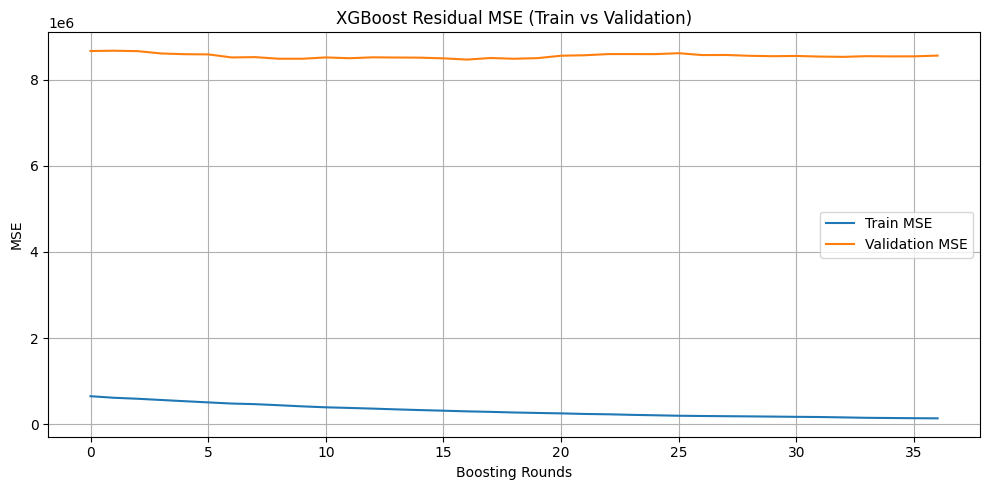


Hybrid Validation Results:
MAE: 2672.55
MAPE: 6747.04%


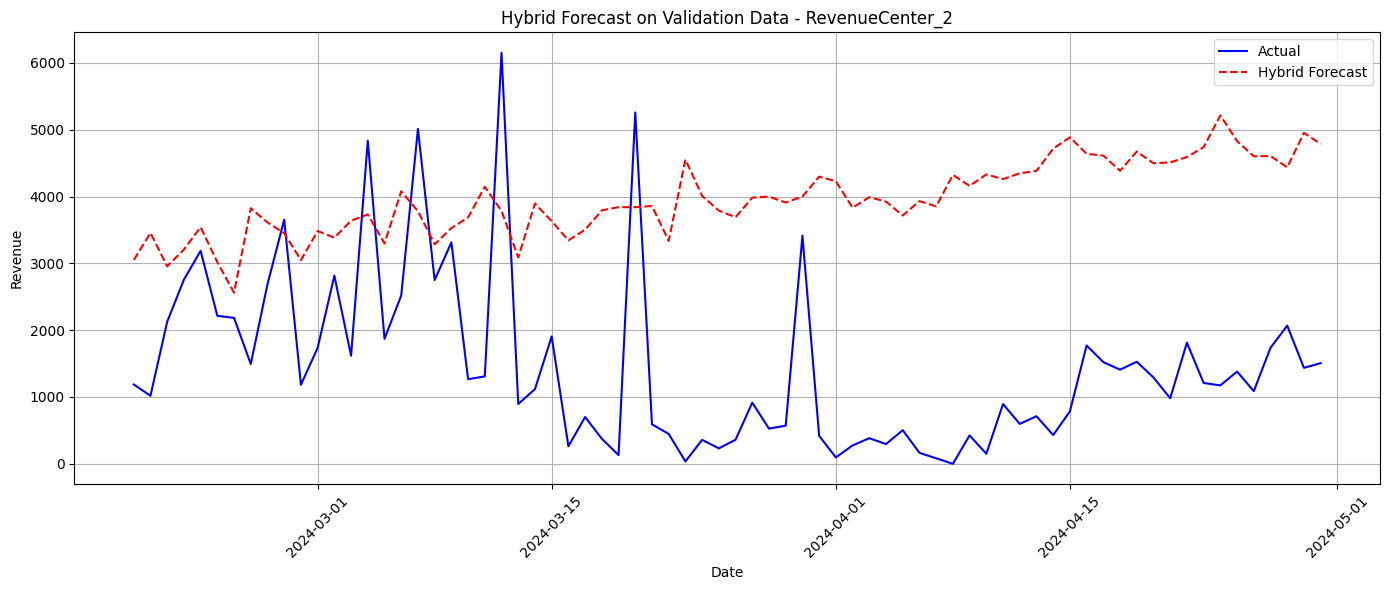

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


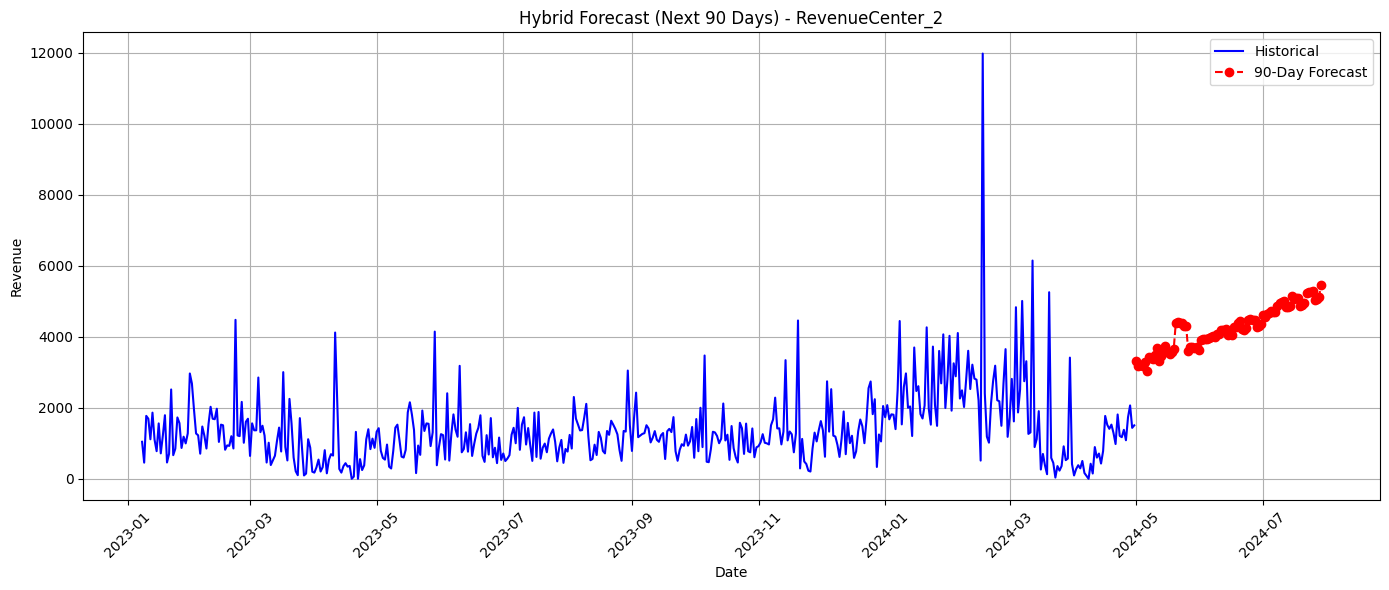

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import holidays
from hijri_converter import convert
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- CONFIG ---
DATA_PATH = "/content/Hotel_Revenue_Data.xlsx"
CENTER = "RevenueCenter_2"
TEST_RATIO = 0.15
FORECAST_DAYS = 90
LAGS = [1, 2, 3, 7,]

# --- LOAD & CLEAN ---
df = pd.read_excel(DATA_PATH, parse_dates=["Date"])
df.rename(columns={"MealPeriod": "Meal Period", "CheckTotal": "Check Total", "RevenueCenterName": "Revenue Center"}, inplace=True)
df = df[df["Revenue Center"] == CENTER]
dfg = df.groupby("Date")["Check Total"].sum().reset_index()

# Fill missing dates
full_dates = pd.date_range(dfg["Date"].min(), dfg["Date"].max(), freq="D")
dfg = dfg.set_index("Date").reindex(full_dates).rename_axis("Date").reset_index()
dfg["Check Total"] = dfg["Check Total"].interpolate()

# Feature engineering
uae_holidays = holidays.country_holidays("AE", years=range(2010, 2025))
dfg["DayOfWeek"] = dfg["Date"].dt.dayofweek
dfg["IsWeekend"] = dfg["DayOfWeek"].isin([5, 6]).astype(int)
dfg["Month"] = dfg["Date"].dt.month
dfg["DayOfMonth"] = dfg["Date"].dt.day
dfg["Holiday"] = dfg["Date"].isin(uae_holidays).astype(int)
dfg["Ramadan"] = dfg["Date"].apply(lambda d: 1 if convert.Gregorian(d.year, d.month, d.day).to_hijri().month == 9 else 0)
dfg["Temp_Proxy"] = dfg["Month"].apply(lambda m: 0.9 if m in [6,7,8] else 0.4 if m in [12,1,2] else 0.6)

for lag in LAGS:
    dfg[f"lag_{lag}"] = dfg["Check Total"].shift(lag)

dfg.dropna(inplace=True)

# Train-validation split
split_idx = int(len(dfg) * (1 - TEST_RATIO))
train_df = dfg.iloc[:split_idx]
valid_df = dfg.iloc[split_idx:]

# --- MANUAL SARIMA ---
sarima_model = SARIMAX(
    train_df["Check Total"],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit()
train_sarima_pred = sarima_result.predict(start=train_df.index[0], end=train_df.index[-1])
train_residuals = train_df["Check Total"].values - train_sarima_pred.values

# --- XGBOOST ON RESIDUALS ---
FEATURES = [f"lag_{lag}" for lag in LAGS] + ["DayOfWeek", "IsWeekend", "Month", "DayOfMonth", "Holiday", "Ramadan", "Temp_Proxy"]
X_train = train_df[FEATURES]
y_train = train_residuals
X_val = valid_df[FEATURES]

# SARIMA forecast for validation
sarima_val_pred = sarima_result.get_forecast(steps=len(valid_df)).predicted_mean
y_val = valid_df["Check Total"].values
residual_val = y_val - sarima_val_pred.values

# XGBoost DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=FEATURES)
dval = xgb.DMatrix(X_val, label=residual_val, feature_names=FEATURES)

# Track RMSE loss
evals_result = {}
xgb_model = xgb.train(
    params={
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": 6,
        "eta": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    },
    dtrain=dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dval, "validation")],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=50
)

# --- LOSS PLOT ---
plt.figure(figsize=(10, 5))
plt.plot(np.square(evals_result["train"]["rmse"]), label="Train MSE")
plt.plot(np.square(evals_result["validation"]["rmse"]), label="Validation MSE")
plt.title("XGBoost Residual MSE (Train vs Validation)")
plt.xlabel("Boosting Rounds")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- HYBRID VALIDATION PREDICTION ---
residual_val_pred = xgb_model.predict(dval)
hybrid_val_pred = sarima_val_pred.values + residual_val_pred

# Validation metrics
mae = mean_absolute_error(y_val, hybrid_val_pred)
mape = np.mean(np.abs((y_val - hybrid_val_pred) / np.maximum(y_val, 1))) * 100
print(f"\nHybrid Validation Results:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot validation
plt.figure(figsize=(14, 6))
plt.plot(valid_df["Date"], y_val, label="Actual", color="blue")
plt.plot(valid_df["Date"], hybrid_val_pred, label="Hybrid Forecast", color="red", linestyle="--")
plt.title(f"Hybrid Forecast on Validation Data - {CENTER}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 90-DAY FORECAST ---
future_dates = pd.date_range(start=dfg["Date"].iloc[-1] + timedelta(days=1), periods=FORECAST_DAYS)
sarima_forecast = sarima_result.get_forecast(steps=FORECAST_DAYS).predicted_mean

# Generate features for forecast
forecast_rows = []
for i, date in enumerate(future_dates):
    row = {
        "DayOfWeek": date.dayofweek,
        "IsWeekend": int(date.dayofweek >= 5),
        "Month": date.month,
        "DayOfMonth": date.day,
        "Holiday": int(date in uae_holidays),
        "Ramadan": 1 if convert.Gregorian(date.year, date.month, date.day).to_hijri().month == 9 else 0,
        "Temp_Proxy": 0.9 if date.month in [6,7,8] else 0.4 if date.month in [12,1,2] else 0.6
    }

    for lag in LAGS:
        lag_date = date - timedelta(days=lag)
        if lag_date in dfg["Date"].values:
            lag_val = dfg[dfg["Date"] == lag_date]["Check Total"].values[0]
        elif lag_date in future_dates:
            idx = (lag_date - future_dates[0]).days
            lag_val = sarima_forecast.iloc[idx] if 0 <= idx < len(sarima_forecast) else sarima_forecast.mean()
        else:
            lag_val = sarima_forecast.mean()
        row[f"lag_{lag}"] = lag_val

    forecast_rows.append(row)

forecast_features = pd.DataFrame(forecast_rows)
dforecast = xgb.DMatrix(forecast_features[FEATURES], feature_names=FEATURES)
residual_forecast = xgb_model.predict(dforecast)
hybrid_forecast = sarima_forecast.values + residual_forecast

# --- PLOT FINAL 3-MONTH FORECAST ---
plt.figure(figsize=(14, 6))
plt.plot(dfg["Date"], dfg["Check Total"], label="Historical", color="blue")
plt.plot(future_dates, hybrid_forecast, label="90-Day Forecast", color="red", marker="o", linestyle="--")
plt.title(f"Hybrid Forecast (Next 90 Days) - {CENTER}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
